### Setup environment

In [2]:
import os
if os.getcwd().split("/")[-1]=="notebooks":
    os.chdir("../../")

### Import

In [3]:
from pyro_risks.utils.fwi_helpers import FWIHelpers
from pyro_risks.utils.s3 import *
from datetime import date
import geopandas as gpd
import numpy as np 

### Connect to s3 bucket

In [4]:
aws_path = "../../../../.aws/"
aws_credentials_path = aws_path+"credentials"
aws_config_path = aws_path+"config"
 
# Get credentials
with open(aws_credentials_path) as f:
    content = f.read().splitlines()
my_access_key_id = content[1].split(" = ")[1]
my_secret_access_key = content[2].split(" = ")[1]

# Get config
with open(aws_config_path) as f:
    content = f.read().splitlines()
my_endpoint = content[8].split(" = ")[1]


s3 = S3Bucket(
                bucket_name='risk',
                endpoint_url=my_endpoint,
                region_name='gra',
                aws_access_key_id=my_access_key_id,
                aws_secret_key=my_secret_access_key
            )


### Download data

In [5]:
today_date_str_url = date.today().strftime('%Y-%m-%d')
effis_tiff_file_url = "https://ies-ows.jrc.ec.europa.eu/effis?LAYERS=ecmwf007.fwi&FORMAT=image/tiff&TRANSPARENT=true&SINGLETILE=false&SERVICE=wms&VERSION=1.1.1&REQUEST=GetMap&STYLES=&SRS=EPSG:4326&BBOX=-6.0,41.0,10.0,52.0&WIDTH=1600&HEIGHT=1200&TIME="+today_date_str_url

today_date_str_url = date.today().strftime('%Y_%m_%d')
filepath_in_bucket = "fwi/fwi_"+today_date_str_url+".geojson"

### download file from EFFIS and convert it to geodf
fwi = FWIHelpers()
gdf_fwi =  fwi.get_fwi(effis_tiff_file_url)


In [6]:
gdf_fwi = fwi.fwi_sea_remover(gdf_fwi)
gdf_fwi['fwi_category'] = gdf_fwi.apply(lambda row: fwi.fwi_category(row['fwi_pixel_value']),axis=1)
gdf_fwi = gdf_fwi.drop('fwi_pixel_value', axis=1)

### Save data

In [7]:
new_json_fwi = fwi.fwi_geojson_maker(gdf_fwi)
new_json_fwi

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'fwi_category': 1},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-4.71, 51.248333333333335],
      [-4.71, 51.11083333333333],
      [-4.640000000000001, 51.11083333333333],
      [-4.640000000000001, 51.248333333333335],
      [-4.71, 51.248333333333335]]]}},
  {'type': 'Feature',
   'properties': {'fwi_category': 1},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-5.2, 52.0],
      [1.4799999999999986, 52.0],
      [1.4799999999999986, 51.954166666666666],
      [1.4099999999999993, 51.954166666666666],
      [1.4099999999999993, 51.880833333333335],
      [1.339999999999999, 51.880833333333335],
      [1.339999999999999, 51.8075],
      [1.2699999999999987, 51.8075],
      [1.2699999999999987, 51.74333333333333],
      [0.9799999999999986, 51.74333333333333],
      [0.9799999999999986, 51.5325],
 

In [8]:
s3.write_json_to_s3(
    object_key= filepath_in_bucket,
    json_data=new_json_fwi)

### Test
After locally downloading the file we just uploaded.

<Axes: >

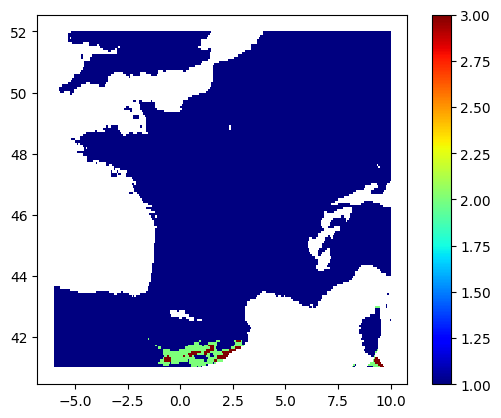

In [9]:
gdf = gpd.read_file("/Users/camillemodeste/Desktop/test_fwi/fwi_2023_11_03.geojson")
gdf.plot(column='fwi_category',cmap="jet", legend=True)